In [52]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
from tqdm import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
elec_raw = pd.read_csv('ELEC.txt', sep="\n", header=None)

In [3]:
l = []
m = []
with tqdm(total=elec_raw.shape[0]) as pbar:
    for i, row in elec_raw.itertuples():
        try:
            l.append(pd.DataFrame(ast.literal_eval(row)))
        except:
            m.append(i)
        pbar.update()

100%|██████████| 588043/588043 [14:13<00:00, 688.73it/s]  


In [4]:
elec = pd.concat(l)

In [5]:
del l

In [6]:
elec = elec.set_index(np.arange(elec.shape[0]))

In [7]:
elec = elec.drop(columns=['category_id', 'childseries', 'copyright', 'description', 'end',
                            'f', 'geoset_id', 'iso3166', 'last_updated','latlon', 'notes', 
                            'parent_category_id', 'series_id', 'source', 'start']).dropna()

In [8]:
years  = np.empty(elec.data.values.shape[0])
months = np.empty(elec.data.values.shape[0])
values = np.empty(elec.data.values.shape[0])
for i, item in enumerate(elec.data.values):
    years[i]  = int(item[0][0:4])
    values[i] = item[-1]
    try:
        months[i] = int(item[0][-2:])
    except:
        months[i] = None

In [ ]:
elec['value'] = values
elec['year'] = years
elec['month'] = months
elec['day'] = 1

In [10]:
states = []
for i, item in enumerate(elec.geography.values):
    states.append(item[-2:])

In [11]:
elec['state'] = states

In [12]:
elec = elec.drop(columns=['data', 'geography']).dropna()

In [13]:
consump_or_gens = np.empty(elec.name.values.shape[0])
power_types = []
for i, item in enumerate(elec.name.values):
    name_as_list = item.split(' : ')
    if name_as_list[0] == 'Electric fuel consumption MMBtu':
        consump_or_gens[i] = 1
    elif name_as_list[0] == 'Net generation':
        consump_or_gens[i] = 0
    else:
        consump_or_gens[i] = None
    power_types.append(name_as_list[2])

In [14]:
elec['consump_or_gen'] = consump_or_gens
elec['power_type'] = power_types

In [15]:
elec = elec.dropna()

In [16]:
elec.month = elec.month.astype(int)
elec.year = elec.year.astype(int)
elec['datetime'] = pd.to_datetime(elec[['year', 'month', 'day']], errors='coerce')

In [17]:
mmbtu_to_mwh_val = 0.29329722222222

In [18]:
elec['mwh'] = elec[elec.units == 'MMBtu'].value * mmbtu_to_mwh_val

In [19]:
elec.mwh.fillna(elec.value, inplace=True)

In [20]:
elec = elec[(elec.units.values == ['MMBtu']) | (elec.units.values == ['megawatthours'])]

In [21]:
elec.lat = elec.lat.astype(float)
elec.lon = elec.lon.astype(float)

In [25]:
elec.to_csv('elec_cleaned.csv')

/Users/Yacalis/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:853: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


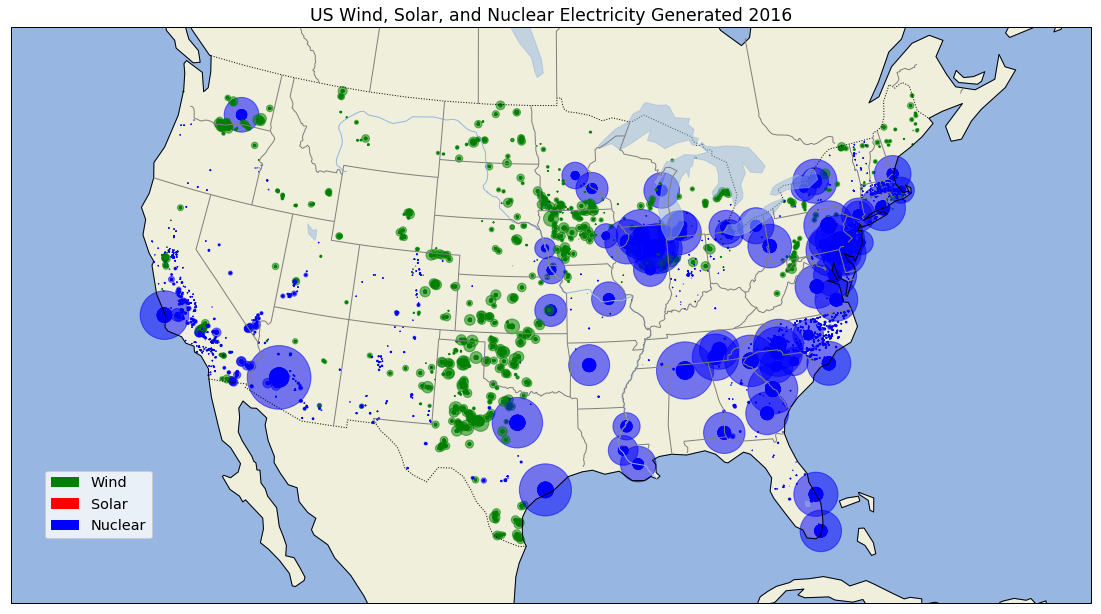

In [82]:
elec_plot = elec[
    ((elec.power_type == 'wind') | (elec.power_type == 'solar') | (elec.power_type == 'nuclear')) & 
    (elec.year == 2016) & 
    (elec.consump_or_gen == 0)
]

fig = plt.figure(figsize=(15,10))

ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

lats = elec_plot.lat
lons = elec_plot.lon
sizes = elec_plot.mwh / 8000

colors = []
for i, ptype in enumerate(elec_plot.power_type):
    if ptype == 'wind':
        colors.append('green')
    elif val == 'solar':
        colors.append('red')
    else:
        colors.append('blue')

ax.set_title('US Wind, Solar, and Nuclear Electricity Generated 2016', fontsize='xx-large')

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray')

plt.scatter(lons, lats, s=sizes, c=colors, alpha=0.3, transform=ccrs.Geodetic())

w_generate = patches.Rectangle((0, 0), 1, 1, facecolor="green")
s_generate = patches.Rectangle((0, 0), 1, 1, facecolor="red")
n_generate = patches.Rectangle((0, 0), 1, 1, facecolor="blue")
ax.legend([w_generate, s_generate, n_generate], ['Wind', 'Solar', 'Nuclear'], 
          loc='lower left', bbox_to_anchor=(0.025, 0.1), fancybox=True, fontsize='x-large')

plt.show()

In [143]:
'coal' in elec_plot.power_type.iloc[0]

True

/Users/Yacalis/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:853: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


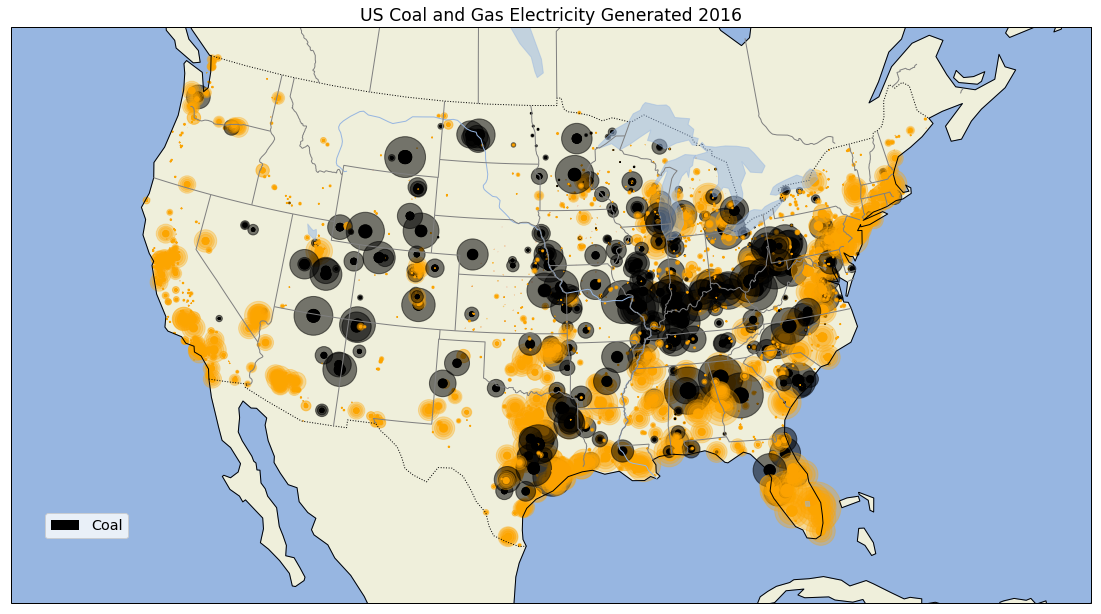

In [145]:
elec_plot = elec[
    ((elec.power_type.str.contains('coal')) | (elec.power_type.str.contains('gas'))) & 
    (elec.year == 2016) & 
    (elec.consump_or_gen == 0)
]

fig = plt.figure(figsize=(15,10))

ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

lats = elec_plot.lat
lons = elec_plot.lon
sizes = elec_plot.mwh / 8000

colors = []
for i, ptype in enumerate(elec_plot.power_type):
    if 'coal' in ptype:
        colors.append('black')
    else:
        colors.append('orange')

ax.set_title('US Coal and Gas Electricity Generated 2016', fontsize='xx-large')

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray')

plt.scatter(lons, lats, s=sizes, c=colors, alpha=0.3, transform=ccrs.Geodetic())

c_generate = patches.Rectangle((0, 0), 1, 1, facecolor="black")
g_generate = patches.Rectangle((0, 0), 1, 1, facecolor="orange")
ax.legend([c_generate], ['Coal', 'Gas'], 
          loc='lower left', bbox_to_anchor=(0.025, 0.1), fancybox=True, fontsize='x-large')

plt.show()

In [154]:
elec_plot = elec.copy(deep=True)[(elec.consump_or_gen == 0)]
elec_plot = elec_plot.dropna()
elec_plot = elec_plot.set_index(elec_plot.datetime)

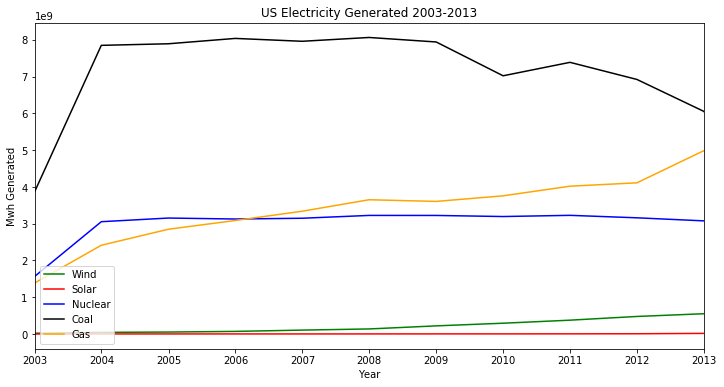

In [157]:
fig = plt.figure(figsize=(12,6))
ax = plt.subplot()

w = elec_plot[elec_plot.power_type == 'wind'].mwh.resample('A').sum()
s = elec_plot[elec_plot.power_type == 'solar'].mwh.resample('A').sum()
n = elec_plot[elec_plot.power_type == 'nuclear'].mwh.resample('A').sum()
c = elec_plot[elec_plot.power_type.str.contains('coal')].mwh.resample('A').sum()
g = elec_plot[elec_plot.power_type.str.contains('gas')].mwh.resample('A').sum()

plt.plot(w, c = 'green')
plt.plot(s, c = 'red')
plt.plot(n, c = 'blue')
plt.plot(c, c = 'black')
plt.plot(g, c = 'orange')
ax.set_xlim('2003', '2013')
ax.set_xlabel('Year')
ax.set_ylabel('Mwh Generated')
ax.set_title('US Electricity Generated 2003-2013')
ax.legend(('Wind', 'Solar', 'Nuclear', 'Coal', 'Gas'), loc='lower left')